In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sklearn.model_selection
import cv2

# SYDE 522 Final Project

## By Anirudh Kilambi and Youngwoo Lee

The purpose of this project is to apply techniques used in class to detect and identify faults and defects found in sewer pipelines. To accomplish this, we used training data found from the 2022 VideoPipe challenge for Real-World Video Understanding for Urban Pipe Inspection. For this project, we investigated the effectiveness of Convolutional Neural Networks (CNN) and Support Vector Machines (SVM) in order to come to an experimental conclusion on which model is most effective for this task.

## Data Loading

In [7]:
# the path to all the raw videos broken up frame by frame
# folder structure should be:
    # raw_images
    #  | video_name
    #       | frame_number.jpg
raw_data_path = "data/raw_images/"

# these are the videos we want to consider, first index is the folder inside raw_images, second index is the categorization (0 = no defect, 1 = defect)
# third index is a range of frames to exclude -- if Tuple is None than include all frames.
# all defect videos have wall obstructions
categorization = [("4736", 0, (None,)), ("2383", 0, (None,)), ("3520",0, (61,570)),  ("d20017", 1, (None,)),
                   ("26852", 1, (None,)), ("5013", 1, (None,)), ("4657", 0, (None,)), ("690", 0, (None,)), 
                  ("5257", 0, (None,)), ("d10169", 1, (None,)), ("2393", 0, (None,)), ("d224", 1, (None,)), ("3196", 0, (None,)),
                  ("d10169", 1, (None,)), ("d22729", 1, (None,)), ("2099", 0, (None,)), ("4644", 0, (None,))]

# this is to split up relative paths to each individual frame. We are considering all frames for an individual video to have the same categorization, 
# we will have a pseudo "dataset" of (paths to frames, category)
sewer_data = {}
sewer_data["data"] = []
sewer_data["target"] = []
for folder, cat, exclusion_range in categorization:
    images = os.listdir(f"{raw_data_path}{folder}/")
    if exclusion_range[0] is None:
        for image in images:
            sewer_data["data"].append(f"{raw_data_path}{folder}/{image}")
            sewer_data["target"].append(cat)
    else:
        exclusion_start = exclusion_range[0]
        exclusion_end = exclusion_range[1]
        for image in images:
            frame_num = int(image.split(".")[0])
            if frame_num >= exclusion_start and frame_num <= exclusion_end:
                continue
            else:
                sewer_data["data"].append(f"{raw_data_path}{folder}/{image}")
                sewer_data["target"].append(cat)


    
# split the data into training, testing and validation
x = sewer_data["data"]
y = sewer_data["target"]
x_trainvalid, x_test, y_trainvalid, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)
print(len(y), len(y_train,), len(y_test), len(y_valid))

8447 6757 1690 1690


In [8]:
# once the "training" data is split, we need to store it into folders. This is so we can use keras' image dataset from directory to
# read in all the data, and have it correctly categorized/labelled.
# This requires the following folder structure.
    # data (= to "type" below)
    #   | category (0, or 1)
    #       | image name
# all image names need to be prefixed with the video name, as originally each video's frames have the same naming convention in raw_data, frame_{frame_number}.jpg
# final image name in this data folder is: {video_name}_frame_{frame_number}.jpg
def moveFiles(x,y,type):
    xpath = f"data/{type}/0/"
    ypath = f"data/{type}/1/"
    if not os.path.exists(xpath):
        os.makedirs(xpath)
    if not os.path.exists(ypath):
        os.makedirs(ypath)
    
    for i in range(len(x)):
        x_split = x[i].split("/")
        img_name = x_split[2] + x_split[3]

        if y[i] == 0:
            os.system(f"cp {x[i]} {xpath}/{img_name}")
        else:
            os.system(f"cp {x[i]} {ypath}/{img_name}")

# delete the folders if they exist
if os.path.exists("data/train/"):
    os.system("rm -fr data/train/")
if os.path.exists("data/test/"):
    os.system("rm -fr data/test/")
if os.path.exists("data/valid/"):
    os.system("rm -fr data/valid/")

moveFiles(x_train, y_train, "train")
moveFiles(x_test, y_test, "test")
moveFiles(x_valid, y_valid, "valid")

In [9]:
# originally, all images are 1280x720 in RGB. This needs to be resized to a smaller resolution due to compute limitations.
# Since the original images are in 16:9, 640x360 was chosen for the resized image. These images all get rewritten with this resize.
base_path = f"data"
types = ["valid", "train", "test"]
for type in types:
    type_base_path = f"{base_path}/{type}/"
    categories = os.listdir(type_base_path)
    for category in categories:
        category_base_path = f"{type_base_path}{category}/"
        images = os.listdir(category_base_path)
        for image in images:
            image_path = f"{category_base_path}{image}"
            img = cv2.imread(image_path)
            resized_image = cv2.resize(img, (640, 360))
            cv2.imwrite(image_path, resized_image)


In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/train/',
    labels='inferred',
    label_mode='categorical',
    image_size=(640, 360))

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(640, 360))

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/valid/',
    labels='inferred',
    label_mode='categorical',
    image_size=(640, 360))

print(valid_ds)

Found 6561 files belonging to 2 classes.
Found 1678 files belonging to 2 classes.
Found 1678 files belonging to 2 classes.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 640, 360, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## Part 1: Convolutional Neural Networks 

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape = (640, 360, 3)), # shape of the original images are RGB colored 640 x 360 res.
  tf.keras.layers.Flatten(input_shape=(640, 360, 3)), # flatten the images to reduce the spatial layer for classification improvements.
  tf.keras.layers.Dense(32, activation='relu'), # dense middle layer, 32 Neurons.    
  tf.keras.layers.Dense(2, activation='softmax') # final categorization layer, there are only two categories so should only have 2 Neurons
])

def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer="adam", 
              loss=my_loss,
              metrics=['accuracy'] 
             )

model.fit(train_ds, epochs=5, validation_data=valid_ds)
# loss, accuracy = model.evaluate(test_ds)

Epoch 1/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.5497 - loss: 0.4503 - val_accuracy: 0.5348 - val_loss: 0.4652
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.5523 - loss: 0.4477 - val_accuracy: 0.5348 - val_loss: 0.4652
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.5522 - loss: 0.4478 - val_accuracy: 0.5348 - val_loss: 0.4652
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.5511 - loss: 0.4489 - val_accuracy: 0.5348 - val_loss: 0.4652
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5527 - loss: 0.4473 - val_accuracy: 0.5348 - val_loss: 0.4652


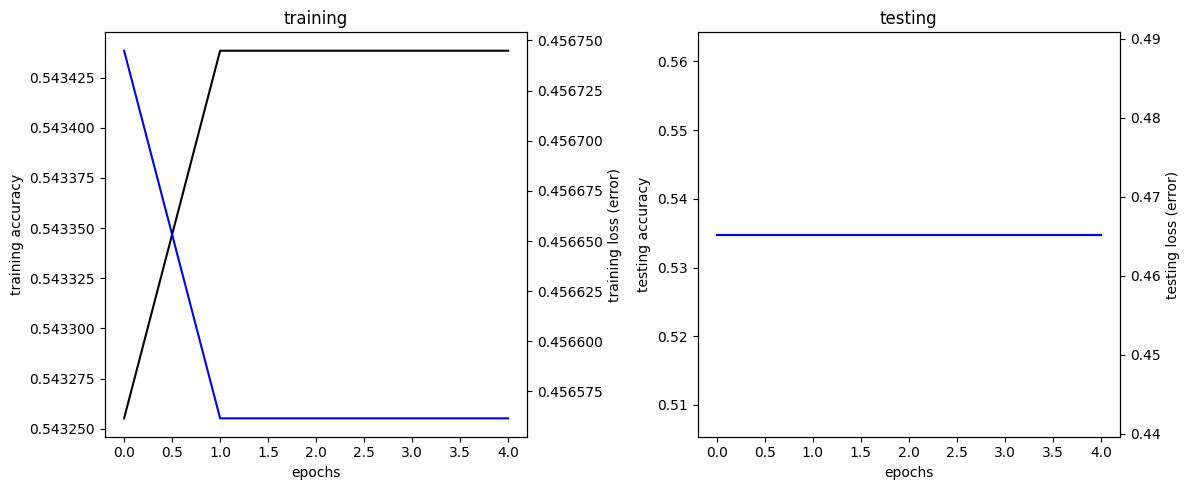

In [31]:

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

# Analysis of Initial Model
This simple model was derived from class work in SYDE 522 as a starting point. The only major change made with this model were th einput shapes. All images for this dataset are $640 \times 360 \times 3$  as they are 360P colour images.
The shapes had to be updated to reflect that. Additionally, the final layer that determines the probability of a categorization needed to 2 units, as the categorization for this model is binary.

The model performed quite poorly, with a constant validation accuracy and loss. Additionally, training accuracy remained relatively constant around 0.45 with a final testing accuracy of 0.46.

## Potential improvements
An initial change that needs to be made is the use of the `my_loss` function. The loss function used does a simple squared error calculation. However, with this categorization model with a non-continuous dataset, this loss function
is poorly suited. The categorical crossentropy loss function will penalize predictions that diverge from the true probability distribution of the data. The sparse categorical crossentropy loss function will be used.

Additionally, some initial feature extraction would be beneficial. A Conv2D layer can be used to extract patterns in the textures of the images. This will be helpful to identify similar features found in different locations in the pipe. As this model is serving as a baseline study into optimization for a larger model, this should be helpful in improving testing performance. As this initial feature extraction is meant to help the model identify and learn. It will replace the original `keras.layers.InputLayer` used.

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 360, 3)),
  # tf.keras.layers.InputLayer(input_shape = (640, 360, 3)), # shape of the original images are RGB colored 640 x 360 res.
  tf.keras.layers.Flatten(), # flatten the images to reduce the spatial layer for classification improvements.
  tf.keras.layers.Dense(32, activation='relu'), # dense middle layer, 32 Neurons.    
  tf.keras.layers.Dense(2, activation='softmax') # final categorization layer, there are only two categories so should only have 2 Neurons
])

model.compile(optimizer="adam", 
              # loss="sparse_categorical_crossentropy",
              loss="categorical_crossentropy",
              metrics=['accuracy'] 
             )

model.fit(train_ds, epochs=5, validation_data=valid_ds)
# loss, accuracy = model.evaluate(test_ds)

/Users/Anirudh.Kilambi/.virtualenvs/ml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


2024-12-14 22:17:00.156504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


171/171 ━━━━━━━━━━━━━━━━━━━━ 103s 583ms/step - accuracy: 0.7113 - loss: 47757.7656 - val_accuracy: 0.9582 - val_loss: 209.5422
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 101s 588ms/step - accuracy: 0.8787 - loss: 2749.1907 - val_accuracy: 0.6139 - val_loss: 14473.2744
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 98s 571ms/step - accuracy: 0.8846 - loss: 5785.2144 - val_accuracy: 0.8212 - val_loss: 13408.7939
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 97s 562ms/step - accuracy: 0.8886 - loss: 8938.7715 - val_accuracy: 0.6740 - val_loss: 32203.4395
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 97s 562ms/step - accuracy: 0.8886 - loss: 12612.2188 - val_accuracy: 0.9319 - val_loss: 8202.1152


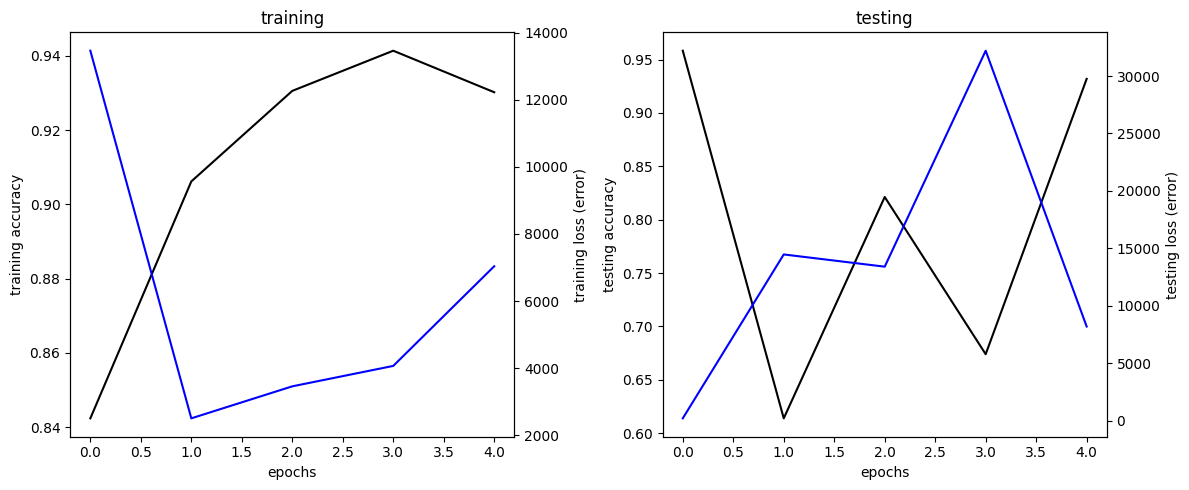

In [5]:


plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

In [9]:
loss, accuracy = model.evaluate(test_ds)
print(loss, accuracy)

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.6219 - loss: 67679.0938
73835.3671875 0.624908447265625


# Rerunning the above model.

In [7]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 360, 3)),
  # tf.keras.layers.InputLayer(input_shape = (640, 360, 3)), # shape of the original images are RGB colored 640 x 360 res.
  tf.keras.layers.Flatten(), # flatten the images to reduce the spatial layer for classification improvements.
  tf.keras.layers.Dense(32, activation='relu'), # dense middle layer, 32 Neurons.    
  tf.keras.layers.Dense(2, activation='softmax') # final categorization layer, there are only two categories so should only have 2 Neurons
])

model.compile(optimizer="adam", 
              # loss="sparse_categorical_crossentropy",
              loss="categorical_crossentropy",
              metrics=['accuracy'] 
             )

model.fit(train_ds, epochs=5, validation_data=valid_ds)
# loss, accuracy = model.evaluate(test_ds)

Epoch 1/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 151s 874ms/step - accuracy: 0.7307 - loss: 58788.1445 - val_accuracy: 0.9451 - val_loss: 473.5337
Epoch 2/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 142s 831ms/step - accuracy: 0.9305 - loss: 777.5260 - val_accuracy: 0.4674 - val_loss: 57060.5469
Epoch 3/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 151s 878ms/step - accuracy: 0.8524 - loss: 10975.4043 - val_accuracy: 0.4989 - val_loss: 60882.5195
Epoch 4/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 152s 887ms/step - accuracy: 0.8700 - loss: 14790.0889 - val_accuracy: 0.7179 - val_loss: 38739.6484
Epoch 5/5
171/171 ━━━━━━━━━━━━━━━━━━━━ 154s 895ms/step - accuracy: 0.8692 - loss: 22452.8809 - val_accuracy: 0.6256 - val_loss: 73856.3828


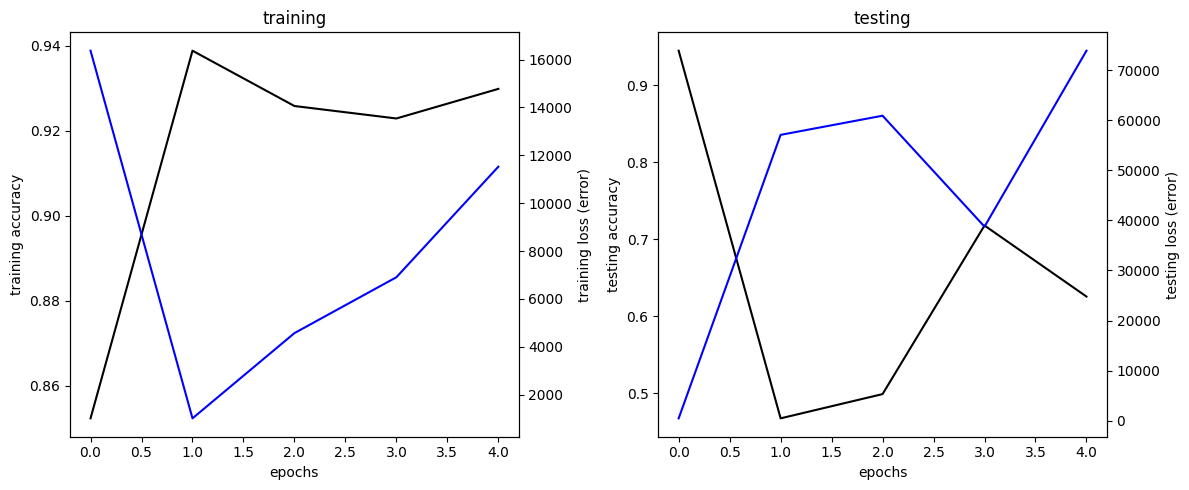

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

# Evaluating the Changes
After implementing the `Conv2D` layer, as well as updating the loss function to `categorical_crossentropy`, significant improvements were found in the training process. After five epochs, validation accuracy was improved by over 30%. The testing accuracy was improved by $14\%$. A simple test would be to increase the number of epochs and see how the system is affected.

## Testing Accuracy over Epochs

/Users/Anirudh.Kilambi/.virtualenvs/ml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 140s 803ms/step - accuracy: 0.5830 - loss: 68772.2656 - val_accuracy: 0.7194 - val_loss: 2883.5066
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.7373 - loss: 2371.1682
Epoch 1/2
171/171 ━━━━━━━━━━━━━━━━━━━━ 145s 836ms/step - accuracy: 0.7696 - loss: 25706.2617 - val_accuracy: 0.9875 - val_loss: 37.9567
Epoch 2/2
171/171 ━━━━━━━━━━━━━━━━━━━━ 143s 831ms/step - accuracy: 0.9713 - loss: 549.7558 - val_accuracy: 0.9897 - val_loss: 353.7681
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9950 - loss: 167.3576
Epoch 1/3
171/171 ━━━━━━━━━━━━━━━━━━━━ 147s 847ms/step - accuracy: 0.6069 - loss: 43680.9180 - val_accuracy: 0.9487 - val_loss: 170.3501
Epoch 2/3
171/171 ━━━━━━━━━━━━━━━━━━━━ 142s 829ms/step - accuracy: 0.8973 - loss: 627.7524 - val_accuracy: 0.5348 - val_loss: 47555.3320
Epoch 3/3
171/171 ━━━━━━━━━━━━━━━━━━━━ 143s 831ms/step - accuracy: 0.7899 - loss: 10072.2891 - val_accuracy: 0.9377 - val_loss: 824.5005
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms

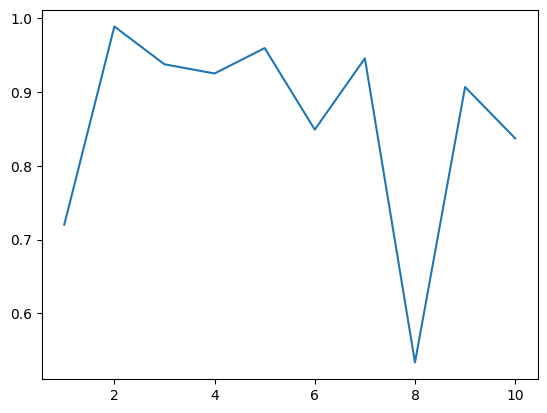

In [10]:
def model_epochs(epoch):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 360, 3)),
    # tf.keras.layers.InputLayer(input_shape = (640, 360, 3)), # shape of the original images are RGB colored 640 x 360 res.
    tf.keras.layers.Flatten(), # flatten the images to reduce the spatial layer for classification improvements.
    tf.keras.layers.Dense(32, activation='relu'), # dense middle layer, 32 Neurons.    
    tf.keras.layers.Dense(2, activation='softmax') # final categorization layer, there are only two categories so should only have 2 Neurons
    ])

    model.compile(optimizer="adam", 
                # loss="sparse_categorical_crossentropy",
                loss="categorical_crossentropy",
                metrics=['accuracy'] 
                )
    model.fit(train_ds, epochs=epoch, validation_data=valid_ds)
    loss, accuracy = model.evaluate(test_ds)
    return (loss, accuracy)

epochs = np.arange(1,11,1)
result = [model_epochs(e) for e in epochs]
epoch_losses = [r[0] for r in result]
epoch_accuracies = [r[1] for r in result]

plt.figure()
plt.plot(epochs,epoch_accuracies)
plt.show()

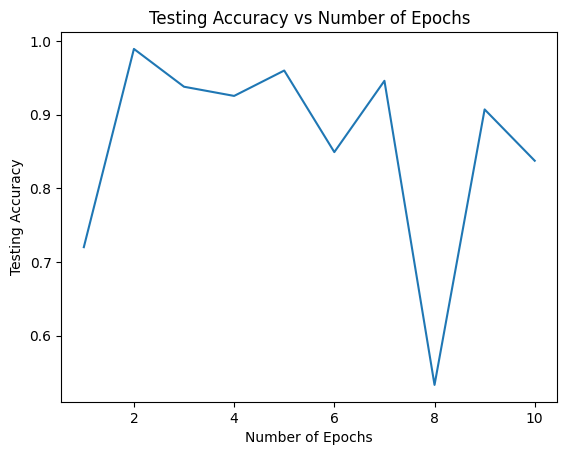

In [12]:
plt.figure()
plt.xlabel("Number of Epochs")
plt.ylabel("Testing Accuracy")
plt.title("Testing Accuracy vs Number of Epochs")
plt.plot(epochs,epoch_accuracies)
plt.show()

# Analysis of Epochs
The graph shows that testing accuracy stabilized between 2-5 epochs. Considering the increase in training time for the longer epochs, it was decided to use 5 epochs to train the model. To further validate. One potential concern with the data is potential overfitting. Although over 1000 frames are used, many of them can be similar. To improve generalization, and reduce the computational cost, reducing the size of the inputs by using a max pooling layer could be beneficial after the Conv2D layer.

Epoch 1/5


2024-12-15 19:25:49.193772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


206/206 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.7407 - loss: 14096.6270 - val_accuracy: 0.9702 - val_loss: 3.8868
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9920 - loss: 0.6500 - val_accuracy: 0.9851 - val_loss: 1.8819
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9930 - loss: 1.2256 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.9996 - loss: 0.0206 - val_accuracy: 0.9905 - val_loss: 1.1862
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9986 - loss: 0.2745 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


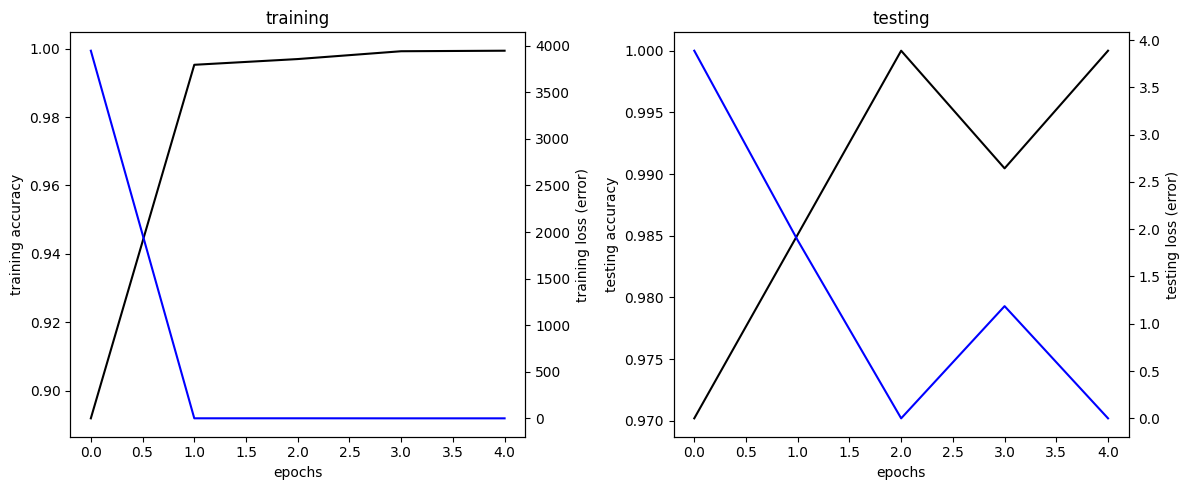

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(640, 360, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),  # Reduce spatial dimensions
  tf.keras.layers.Flatten(), # flatten the images to reduce the spatial layer for classification improvements.
  tf.keras.layers.Dense(32, activation='relu'), # dense middle layer, 32 Neurons.    
  tf.keras.layers.Dense(2, activation='softmax') # final categorization layer, there are only two categories so should only have 2 Neurons
])

model.compile(optimizer="adam", 
              # loss="sparse_categorical_crossentropy",
              loss="categorical_crossentropy",
              metrics=['accuracy'] 
             )

model.fit(train_ds, epochs=5, validation_data=valid_ds)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

# loss, accuracy = model.evaluate(test_ds)

# Implementing a Larger Dataset

By implementing a max pooling layer to the model, significant improvements in training accuracy were achieved. However, at perfect accuracy. There are clear signs of overfitting. To better evaluate this performance, a larger dataset should be used.

In [14]:
import json
# the path to all the raw videos broken up frame by frame
# folder structure should be:
    # raw_images
    #  | video_name
    #       | frame_number.jpg
raw_data_path = "data/raw_images/"

# these are the videos we want to consider, first index is the folder inside raw_images, second index is the categorization (0 = no defect, 1 = defect)
# third index is a range of frames to exclude -- if Tuple is None than include all frames.
file = open("available_videos.json", "r")
categorization = []
available_videos = json.load(file)
for file_name, defects in available_videos.items():
    video_prefix = file_name.split(".")[0]
    if defects[0] == 0:
        categorization.append((video_prefix, 0, (None,)))
    else:
        categorization.append((video_prefix, 1, (None,)))

# this is to split up relative paths to each individual frame. We are considering all frames for an individual video to have the same categorization, 
# we will have a pseudo "dataset" of (paths to frames, category)
sewer_data = {}
sewer_data["data"] = []
sewer_data["target"] = []
for folder, cat, exclusion_range in categorization:
    images = os.listdir(f"{raw_data_path}{folder}/")
    if exclusion_range[0] is None:
        for image in images:
            sewer_data["data"].append(f"{raw_data_path}{folder}/{image}")
            sewer_data["target"].append(cat)
    else:
        exclusion_start = exclusion_range[0]
        exclusion_end = exclusion_range[1]
        for image in images:
            frame_num = int(image.split(".")[0])
            if frame_num >= exclusion_start and frame_num <= exclusion_end:
                continue
            else:
                sewer_data["data"].append(f"{raw_data_path}{folder}/{image}")
                sewer_data["target"].append(cat)


    
# split the data into training, testing and validation
x = sewer_data["data"]
y = sewer_data["target"]
x_trainvalid, x_test, y_trainvalid, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)
print(len(y), len(y_train,), len(y_test), len(y_valid))

179093 143274 35819 35819


In [ ]:

# delete the folders if they exist
if os.path.exists("data/train/"):
    os.system("rm -fr data/train/")
if os.path.exists("data/test/"):
    os.system("rm -fr data/test/")
if os.path.exists("data/valid/"):
    os.system("rm -fr data/valid/")

moveFiles(x_train, y_train, "train")
moveFiles(x_test, y_test, "test")
moveFiles(x_valid, y_valid, "valid")

# originally, all images are 1280x720 in RGB. This needs to be resized to a smaller resolution due to compute limitations.
# Since the original images are in 16:9, 640x360 was chosen for the resized image. These images all get rewritten with this resize.
base_path = f"data"
types = ["valid", "train", "test"]
for type in types:
    print(type)
    type_base_path = f"{base_path}/{type}/"
    categories = os.listdir(type_base_path)
    for category in categories:
        print(category)
        category_base_path = f"{type_base_path}{category}/"
        images = os.listdir(category_base_path)
        for image in images:
            print(image)
            image_path = f"{category_base_path}{image}"
            img = cv2.imread(image_path)
            resized_image = cv2.resize(img, (640, 360))
            cv2.imwrite(image_path, resized_image)

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/train/',
    labels='inferred',
    label_mode='categorical',
    image_size=(640, 360))

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/test/',
    labels='inferred',
    label_mode='categorical',
    image_size=(640, 360))

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory='data/valid/',
    labels='inferred',
    label_mode='categorical',
    image_size=(640, 360))



# Analysis
Implementing a larger dataset was unfeasible due to hardware limitations.


# Let's try changing the number of neurons

In [ ]:

neurons = [8, 16, 32, 64, 128]
losses = []
accuracies = []

for neuron in neurons:

    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(neuron, (3, 3), activation='relu', input_shape=(640, 360, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),  # Reduce spatial dimensions
    tf.keras.layers.Flatten(), # flatten the images to reduce the spatial layer for classification improvements.
    tf.keras.layers.Dense(neuron, activation='relu'), # dense middle layer, 32 Neurons.    
    tf.keras.layers.Dense(2, activation='softmax') # final categorization layer, there are only two categories so should only have 2 Neurons
    ])

    model.compile(optimizer="adam", 
                # loss="sparse_categorical_crossentropy",
                loss="categorical_crossentropy",
                metrics=['accuracy'] 
                )

    model.fit(train_ds, epochs=5, validation_data=valid_ds)
    loss, accuracy = model.evaluate(test_ds)
    losses.append(loss)
    accuracies.append(accuracy)

Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.7655 - loss: 2285.8367 - val_accuracy: 0.9863 - val_loss: 4.5761
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.9896 - loss: 4.4557 - val_accuracy: 0.9994 - val_loss: 0.3654
Epoch 3/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9986 - loss: 0.5846 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9919 - loss: 5.9855 - val_accuracy: 0.9803 - val_loss: 11.4753
Epoch 5/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 20s 97ms/step - accuracy: 0.9837 - loss: 18.0069 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 1/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 29s 135ms/step - accuracy: 0.6961 - loss: 2641.0444 - val_accuracy: 0.7574 - val_loss: 112.3522
Epoch 2/5
206/206 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - accuracy: 0.7843 - loss: 105.1829 - val_accuracy: 0.7688 - val_loss: 106

/Users/Anirudh.Kilambi/.virtualenvs/ml/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


206/206 ━━━━━━━━━━━━━━━━━━━━ 58s 258ms/step - accuracy: 0.5265 - loss: 67166.5938 - val_accuracy: 0.5203 - val_loss: 22598.6953
Epoch 2/5
  8/206 ━━━━━━━━━━━━━━━━━━━━ 11:08 3s/step - accuracy: 0.5573 - loss: 13508.9727